# Predicting the covid-19 mortality in Spain
$Computational Biology:
Shady, Rebeca, Irene, Gemma, Héctor$

During the last two months, over 26,000 people have been reported dead in Spain due to COVID-19. In
order to take measures, such as the reversal of the lockdown, it is important to anticipate the evolution of
the pandemic.
This project develops statistical learning models capable of predicting the weekly mortality figures in Spain and its “autonomous communities” (CCAA). In particular, given the number of deceased in weeks t, t-1, t-2, t-3… (or even in days prior to t) predicts the number of deceased in week t+1.
![covid-19 wallpaper](media/covid.png)


### Reading the file from el Ministerio de Sanidad
First of all, we need to obtain and process the data on the daily number of people reported dead, infected, ICU, diagnosed and recovered. To achive this, we import pandas, matplotib.pyplot and numpy modules. The data will be imported splitted by autonomous communities (CCAA) and acumulated day by day. Note that before this chunk of code we had to remove the last lines of the file given by "El Ministerio de Sanidad"; otherwise, it was impossible to read it, because there was information in another format!

##### Pandas
Pandas is a Python module that allows you to work with objects that resemble Excel spreedsheets or, if you wish, `R` data frames.
##### matplotlib.pyplot
matplotlib.pyplot is a collection of command style functions that make matplotlib work like MATLAB. Each pyplot function makes some change to a figure: e.g., creates a figure, creates a plotting area in a figure, plots some lines in a plotting area, decorates the plot with labels, etc.
##### numpy
NumPy is a Python package which stands for 'Numerical Python'. It is the core library for scientific computing, which contains a powerful n-dimensional array object, provide tools for integrating C, C++ etc. It is also useful in linear algebra, random number capability etc.

In [0]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
df=pd.read_csv("data/agregados.csv")
df=df.fillna(0)

## Working with acumulated data
Now we are going to create a new dataframe which contains the information simplified. We would like to work firstly on the data of all spain together, not splitted by CCAA. To achive that, we need to remove the CCAA column and sum all the values of each day toguether, otherwise it would still be splitted in regions. Once we have this dataframe, we will be able to plot the data (still acumulated).

In [0]:
columnsDF=df.columns.tolist()
columnsDF.remove('CCAA') #CCAA must be removed; otherwise, once we sum the values, we will have an error
global_df=df[columnsDF].groupby('FECHA').sum()
global_df.index =pd.to_datetime(global_df.index,  format='%d/%m/%Y') #sorted by date since one index was swapped
global_df=global_df.sort_values('FECHA')
global_df=global_df.reset_index() #we want FECHA as a column, not an index
global_df['FECHA'] = global_df['FECHA'].dt.strftime('%d-%m-%Y') #from date format to string since gives problem in the plot
global_df #Data from all spain globally

,FECHA,CASOS,PCR+,TestAc+,Hospitalizados,UCI,Fallecidos
0,20-02-2020,0.0,3,0.0,26.0,0.0,0.0
1,21-02-2020,0.0,3,0.0,30.0,1.0,0.0
2,22-02-2020,0.0,3,0.0,33.0,1.0,0.0
3,23-02-2020,0.0,3,0.0,38.0,2.0,0.0
4,24-02-2020,0.0,4,0.0,49.0,2.0,0.0
...,...,...,...,...,...,...,...
86,16-05-2020,0.0,231651,46369.0,123835.0,11378.0,27634.0
87,17-05-2020,0.0,231966,46582.0,123991.0,11391.0,27693.0
88,18-05-2020,0.0,232246,46766.0,124421.0,11403.0,27793.0
89,19-05-2020,0.0,232693,46969.0,124381.0,11434.0,27892.0


### Visualization of the data acumulated of all Spain.

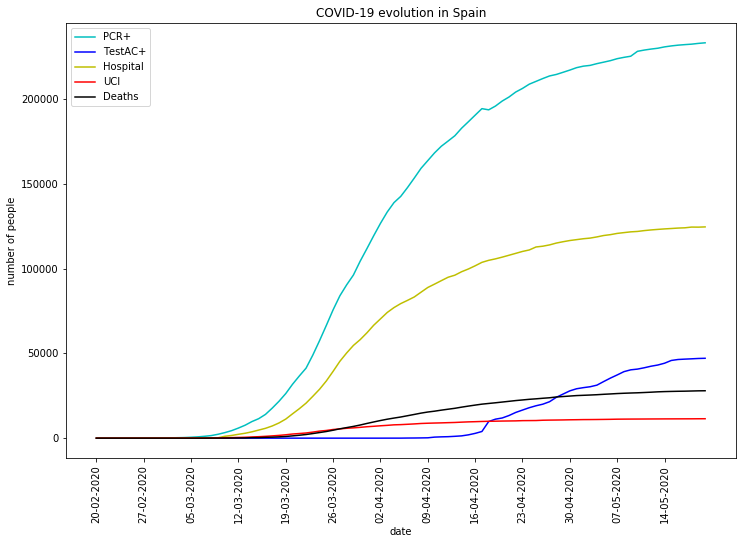

In [0]:
plt.figure(figsize=(12,8))
plt.plot(global_df.FECHA, global_df[['PCR+']], 'c', label="PCR+")
plt.plot(global_df.FECHA, global_df[['TestAc+']], 'b', label="TestAC+")
plt.plot(global_df.FECHA, global_df[['Hospitalizados']], 'y', label="Hospital")
plt.plot(global_df.FECHA, global_df[['UCI']], 'r', label='UCI')
plt.plot(global_df.FECHA, global_df[['Fallecidos']], 'k', label='Deaths')
plt.legend()
plt.title('COVID-19 evolution in Spain')
plt.xticks(np.arange(0, global_df['FECHA'].nunique(), 7.0),rotation=90) #rotate X label and set a tick
plt.xlabel('date')
plt.ylabel('number of people')
plt.show()

In this plot we can see the covid-19 evolution in Spain. The most increased value is the number of PCR+ which has been increasing strongly in time caused also by the discovery of previous patients not diagnosticated. At the end, we can observe that this growth has been smoother, due to the slowing down of the pandemic.

## Working with non-cumulative data
Now that we have seen all the values represented, we want to apply statistical learning and linear regression. If we want to calculate te probability of a day in the future, we need information of the previous day, weeks, etc. Right now we have the data accumulated, in other words, the linear regression would need to train a model with enormous values. For that reason, now we are going to calculate the increase data of each day individually. As a result, we will have a better and faster model to work.

In [0]:
#We transform the data from cumulated to not cumulated
regional_df=df.copy()
regional_df_dummy=df.copy()
del regional_df["CASOS"]

pd.options.mode.chained_assignment = None  # default='warn'
for i in regional_df[regional_df.columns[2:]]:#skip the first 2 column (CCAA date)
    for j in range(len(regional_df.index),0,-1): #backwards for cycle; range(start, stop, step)
        if (j-1)>=20: #skip element 0
            regional_df.at[j-1,i]=regional_df_dummy.iloc[j-1][i]-regional_df_dummy.iloc[j-20][i]
#(j-1) (is a community at a day X) ////(j-20) is the same community at day X-1 (since exist 19 communities)
regional_df 

,CCAA,FECHA,PCR+,TestAc+,Hospitalizados,UCI,Fallecidos
0,AN,20/2/2020,0,0.0,0.0,0.0,0.0
1,AR,20/2/2020,0,0.0,0.0,0.0,0.0
2,AS,20/2/2020,0,0.0,0.0,0.0,0.0
3,IB,20/2/2020,1,0.0,0.0,0.0,0.0
4,CN,20/2/2020,1,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...
1724,ML,20/5/2020,0,0.0,0.0,0.0,0.0
1725,MC,20/5/2020,10,0.0,1.0,0.0,1.0
1726,NC,20/5/2020,3,0.0,0.0,0.0,3.0
1727,PV,20/5/2020,9,0.0,8.0,0.0,3.0


In [0]:
#we eliminate all the negative values with the mean of the previous and next value of the same community
pd.options.mode.chained_assignment = None  # default='warn'
for i in regional_df[regional_df.columns[2:]]:#skip the first 2 column (CCAA date)
    for j in range(len(regional_df.index),0,-1): #backwards for cycle
        if (j-1)>=20: #skip element 0
            if regional_df.iloc[j-1][i]<0:
                    regional_df.at[j-1,i]=(regional_df.iloc[j+18][i]+regional_df.iloc[j-20][i])/2
#(j-1) (is a community at a day X) ////(j-20) is the same community at day X-1 (since exist 19 communities)

In [0]:
#Now we will create a new data frame which contains the information not cumulated
# and not separated according to the CCAA)
columnsDF=regional_df.columns.tolist()
columnsDF.remove('CCAA') #CCAA must be removed; otherwise, once we sum the values, we will have an error
df_dayly=regional_df[columnsDF].groupby('FECHA').sum()
df_dayly.index =pd.to_datetime(df_dayly.index,  format='%d/%m/%Y') #sorted by date since one index was swapped
df_dayly=df_dayly.sort_values('FECHA')
df_dayly=df_dayly.reset_index() #we want FECHA as a column, not an index
df_dayly['FECHA'] = df_dayly['FECHA'].dt.strftime('%d-%m-%Y') #from date format to string since gives problem in the plot
df_dayly #DATAFRAME WITH GLOBAL DATA (SPAIN) AND NON-CUMULATIVE VALUES

,FECHA,PCR+,TestAc+,Hospitalizados,UCI,Fallecidos
0,20-02-2020,3,0.0,26.0,0.0,0.0
1,21-02-2020,0,0.0,4.0,1.0,0.0
2,22-02-2020,0,0.0,3.0,0.0,0.0
3,23-02-2020,0,0.0,5.0,1.0,0.0
4,24-02-2020,1,0.0,11.0,0.0,0.0
...,...,...,...,...,...,...
86,16-05-2020,448,572.0,257.0,14.0,85.0
87,17-05-2020,315,260.5,156.0,13.0,59.0
88,18-05-2020,456,184.0,430.0,12.0,100.0
89,19-05-2020,447,203.0,201.0,31.0,99.0


## Visualization of the increased daily data and not accumulated

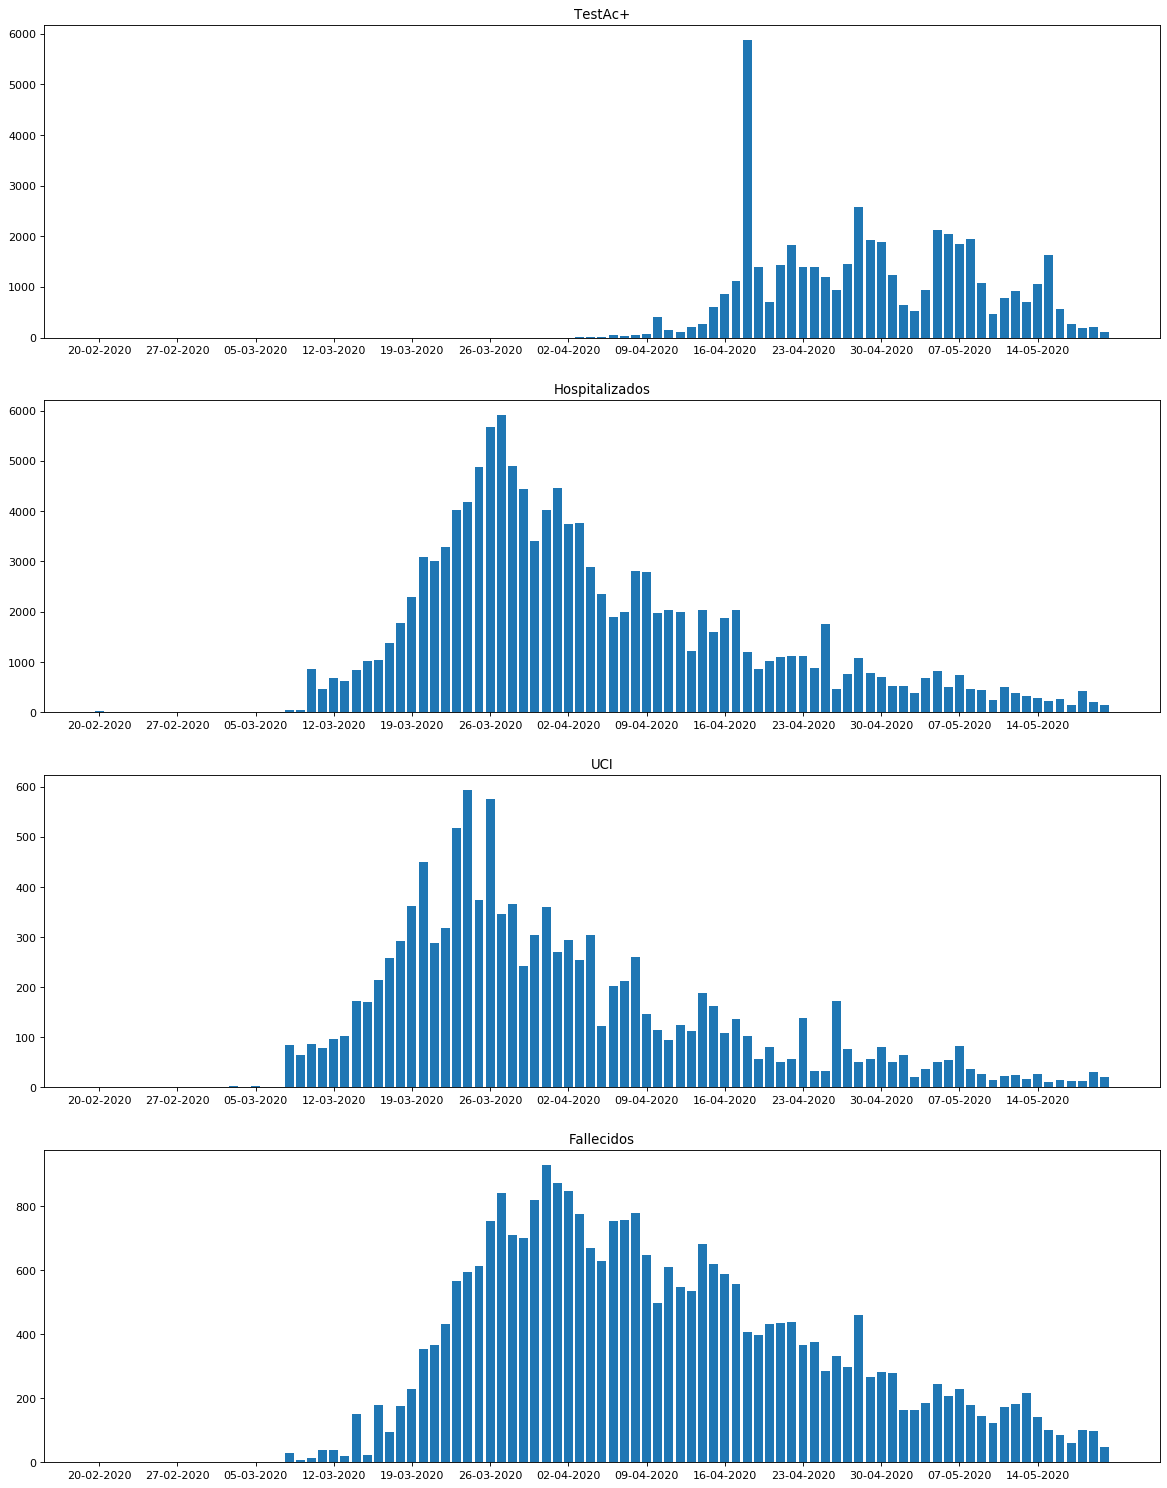

In [0]:
i=0
fig = plt.figure(figsize=(18, 30), dpi= 80, facecolor='w', edgecolor='k')
for x in df_dayly[df_dayly.columns[2:]]:   #remove id and diagnosis columns keep the rest of the dataset
    i=i+1
    plt.subplot(5,1, i)
    plt.bar(df_dayly.FECHA, df_dayly[[x]].iloc[:,0])
    plt.xticks(np.arange(0, df_dayly['FECHA'].nunique(), 7.0))
    plt.title(x)

## At the end of this process we have two main dataset
**regional_df:** daily values divided by comunity

**df_dayly:** daily values for all the country (for all Spain)

In [0]:
display("regional_df: dayly values divided by comunity",regional_df, "df_dayly: dayly values for all the country", df_dayly)

'regional_df: dayly values divided by comunity'

,CCAA,FECHA,PCR+,TestAc+,Hospitalizados,UCI,Fallecidos
0,AN,20/2/2020,0,0.0,0.0,0.0,0.0
1,AR,20/2/2020,0,0.0,0.0,0.0,0.0
2,AS,20/2/2020,0,0.0,0.0,0.0,0.0
3,IB,20/2/2020,1,0.0,0.0,0.0,0.0
4,CN,20/2/2020,1,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...
1724,ML,20/5/2020,0,0.0,0.0,0.0,0.0
1725,MC,20/5/2020,10,0.0,1.0,0.0,1.0
1726,NC,20/5/2020,3,0.0,0.0,0.0,3.0
1727,PV,20/5/2020,9,0.0,8.0,0.0,3.0


'df_dayly: dayly values for all the country'

,FECHA,PCR+,TestAc+,Hospitalizados,UCI,Fallecidos
0,20-02-2020,3,0.0,26.0,0.0,0.0
1,21-02-2020,0,0.0,4.0,1.0,0.0
2,22-02-2020,0,0.0,3.0,0.0,0.0
3,23-02-2020,0,0.0,5.0,1.0,0.0
4,24-02-2020,1,0.0,11.0,0.0,0.0
...,...,...,...,...,...,...
86,16-05-2020,448,572.0,257.0,14.0,85.0
87,17-05-2020,315,260.5,156.0,13.0,59.0
88,18-05-2020,456,184.0,430.0,12.0,100.0
89,19-05-2020,447,203.0,201.0,31.0,99.0


# First Regression model
### Daily dataframe with the previous two days
Now we are going to work with the regional dataframe which has got the daily vaues of **all the country**. In the first regression model we would like to know the data of the two previous days in order to predict the data of the next day.
To get that probabilty we need to use the **LinearRegression()** function. However we need to perform some steps before applying this function.

**1. import Scikit-learn.**
Is a free software machine learning library for the Python programming language. It features various classification, regression and clustering algorithms including support vector machines, random forests, gradient boosting, k-means and DBSCAN, and is designed to interoperate with the Python numerical and scientific libraries NumPy and SciPy.

**2. import Seaborn.**
Seaborn is a Python data visualization library based on matplotlib. It provides a high-level interface for drawing attractive and informative statistical graphics.

**3. Create the t-1 and t-2 dataframe.**
Now we need the values of the two previous days next to the current day, for achiving that we are going to create a new dataframe with a 'for' iteration. This is a requierement before applying LinearRegression(), otherwise the performance of the function wouldn't work.

**4.Plot the correlation of each day.**
Once we got the dataframe ready to be used, we need to know the values that won't help in the linear regression. For that, we will plot with a correlation and see which ones need to be removed.

**5. Apply the LinearRegression and Cross validation**.
Once we have treated the dataframe, we can apply Linear Regression and know the accuracy of the model applying Cross validation with a test and a training dataframes.

### 1, 2. import Scikit-learn and Seaborn

In [0]:
import numpy as np
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import cross_val_score

### 3.  Create the t-1 and t-2 dataframe  


In [0]:
df_dayly_1day=df_dayly.copy()
l=["PCR+_1day","TestAc+_1day","Hospitalizados_1day","UCI_1day","Fallecidos_1day"]
for col in l:
    df_dayly_1day[col] = 0
for i in range(6,11):
    for j in df_dayly_1day.index:
        if j==0:
            df_dayly_1day.at[j,df_dayly_1day.columns[i]]=0
        else:
            df_dayly_1day.at[j,df_dayly_1day.columns[i]]=df_dayly.iloc[j-1][i-5]
del df_dayly_1day['TestAc+']   
del df_dayly_1day['TestAc+_1day'] 
df_dayly_1day

#here we created a dataframe with the values of t and t-1
#we removed TestAc+ because from a previous correlation matrix we saw 0 correlation with the Fallecidos

,FECHA,PCR+,Hospitalizados,UCI,Fallecidos,PCR+_1day,Hospitalizados_1day,UCI_1day,Fallecidos_1day
0,20-02-2020,3,26.0,0.0,0.0,0,0,0,0
1,21-02-2020,0,4.0,1.0,0.0,3,26,0,0
2,22-02-2020,0,3.0,0.0,0.0,0,4,1,0
3,23-02-2020,0,5.0,1.0,0.0,0,3,0,0
4,24-02-2020,1,11.0,0.0,0.0,0,5,1,0
...,...,...,...,...,...,...,...,...,...
86,16-05-2020,448,257.0,14.0,85.0,569,235,11,100
87,17-05-2020,315,156.0,13.0,59.0,448,257,14,85
88,18-05-2020,456,430.0,12.0,100.0,315,156,13,59
89,19-05-2020,447,201.0,31.0,99.0,456,430,12,100


In [0]:
df_dayly_2day=df_dayly_1day.copy()
l2=["PCR+_2day","Hospitalizados_2day","UCI_2day","Fallecidos_2day"]
for col in l2:
    df_dayly_2day[col] = 0
for i in range(9,13):
    for j in df_dayly_2day.index:

        if j==0 :
            df_dayly_2day.at[j,df_dayly_2day.columns[i]]=0
        else:
            df_dayly_2day.at[j,df_dayly_2day.columns[i]]=df_dayly_1day.iloc[j-1][i-4]
df_dayly_2day
#here we created a dataframe with the values of t and t-1 and t-2

,FECHA,PCR+,Hospitalizados,UCI,Fallecidos,PCR+_1day,Hospitalizados_1day,UCI_1day,Fallecidos_1day,PCR+_2day,Hospitalizados_2day,UCI_2day,Fallecidos_2day
0,20-02-2020,3,26.0,0.0,0.0,0,0,0,0,0,0,0,0
1,21-02-2020,0,4.0,1.0,0.0,3,26,0,0,0,0,0,0
2,22-02-2020,0,3.0,0.0,0.0,0,4,1,0,3,26,0,0
3,23-02-2020,0,5.0,1.0,0.0,0,3,0,0,0,4,1,0
4,24-02-2020,1,11.0,0.0,0.0,0,5,1,0,0,3,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
86,16-05-2020,448,257.0,14.0,85.0,569,235,11,100,797,290,26,141
87,17-05-2020,315,156.0,13.0,59.0,448,257,14,85,569,235,11,100
88,18-05-2020,456,430.0,12.0,100.0,315,156,13,59,448,257,14,85
89,19-05-2020,447,201.0,31.0,99.0,456,430,12,100,315,156,13,59


### 4. Plot the correlation
This is the correlation between the values of the two previous days and the current day.

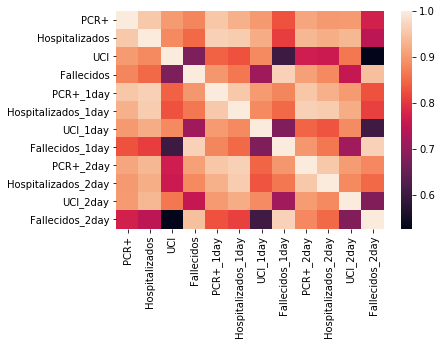

In [0]:
corr = df_dayly_2day.corr()
sns.heatmap(corr, 
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values)

### Removing values
we remove the values of PCR+, Hospitalizados and UCI in t, in order to have only values from t-1 and t-2, with the aim of getting a better LinearReagression().

,FECHA,Fallecidos,PCR+_1day,Hospitalizados_1day,UCI_1day,Fallecidos_1day,PCR+_2day,Hospitalizados_2day,UCI_2day,Fallecidos_2day
0,20-02-2020,0.0,0,0,0,0,0,0,0,0
1,21-02-2020,0.0,3,26,0,0,0,0,0,0
2,22-02-2020,0.0,0,4,1,0,3,26,0,0
3,23-02-2020,0.0,0,3,0,0,0,4,1,0
4,24-02-2020,0.0,0,5,1,0,0,3,0,0
...,...,...,...,...,...,...,...,...,...,...
86,16-05-2020,85.0,569,235,11,100,797,290,26,141
87,17-05-2020,59.0,448,257,14,85,569,235,11,100
88,18-05-2020,100.0,315,156,13,59,448,257,14,85
89,19-05-2020,99.0,456,430,12,100,315,156,13,59


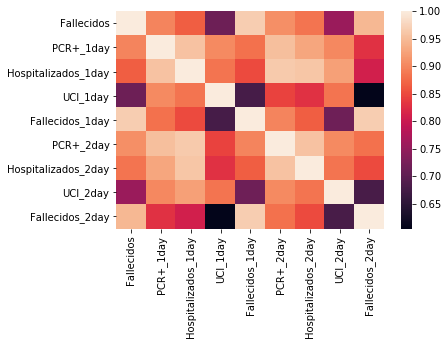

In [0]:
del df_dayly_2day['PCR+']
del df_dayly_2day['Hospitalizados']
del df_dayly_2day['UCI']
corr = df_dayly_2day.corr()
sns.heatmap(corr, 
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values)
df_dayly_2day

### 5. Linear Regression


In [0]:
Y = df_dayly.Fallecidos.values
X=np.column_stack([df_dayly_2day[df_dayly_2day.columns[2:10]].values])
size = int(len(X) * 0.66)
X_train, X_test, y_train, y_test = X[0:size], X[size:(len(X))],Y[0:size], Y[size:(len(Y))]
# Create model
linreg = LinearRegression()
linreg.fit(X_train, y_train)
# Calculate our y predict (how our model performs against the test data held off)
y_pred = linreg.predict(X_test)

'predicted'

[array([388.01864249, 400.94749955, 378.34911332, 413.78473484,
        323.18607983, 386.86543553, 209.94995158, 357.60357181,
        287.57098445, 375.87461798, 281.31148535, 262.67714711,
        277.18913352, 159.87055913, 155.49464677, 167.33518101,
        203.37172714, 217.9842417 , 208.16231295, 188.65908505,
        139.68981632, 201.84092185,  77.6051536 , 165.10652792,
        189.9887744 , 151.07863791,  99.89682431,  78.48961331,
         64.26524937,  77.88649414, 104.1056398 ])]

'real'

[array([432., 434., 439., 365., 377., 286., 332., 297., 459., 265., 281.,
        279., 163., 164., 186., 244., 208., 229., 178., 144., 124., 172.,
        182., 217., 141., 100.,  85.,  59., 100.,  99.,  48.])]

The test MAE is: 51.223271155216956


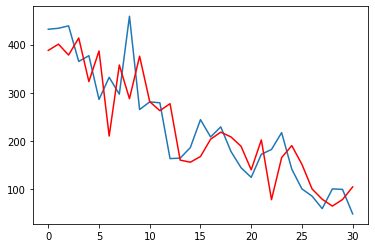

In [0]:
#let's see the result of the regression
display("predicted",[y_pred], "real",[y_test])
from sklearn.metrics import mean_squared_error, mean_absolute_error
test_mse = mean_squared_error(y_test, y_pred)
test_rmse = np.sqrt(test_mse)
# See our Mean Absolute Error
import matplotlib.pyplot as pyplot
test_mae = mean_absolute_error(y_test, y_pred)
print("The test MAE is:",test_mae)
pyplot.plot(y_test)
pyplot.plot(y_pred, color='red')
pyplot.show()

### Coefficients

In [0]:
#coef_ : array, shape (n_features, ) or (n_targets, n_features)
print("Coefficient for [PCR+_1day, Hospitalizados_1day, UCI_1day, Fallecidos_1day, PCR+_2day, Hospitalizados_2day,UCI_2day, Fallecidos_2day]")
print(linreg.coef_)

#intercept_ : array  Independent term in the linear model.

print(linreg.intercept_)

Coefficient for [PCR+_1day, Hospitalizados_1day, UCI_1day, Fallecidos_1day, PCR+_2day, Hospitalizados_2day,UCI_2day, Fallecidos_2day]
[ 0.03151993 -0.04733753 -0.00459509  0.68155937 -0.02708274  0.05250727
  0.23366197  0.14870082]
4.296720737150906


We can see that the 2 features that mainly infer the casualities on week t are the Fallecidos of t-1 and the UCI of t-2

### Cross Validation
we do a cross validation to see the results with different test set and training set

In [0]:
from sklearn.model_selection import cross_val_score
cv_4_results = cross_val_score(linreg, X, Y, cv=4, 
 scoring="neg_mean_absolute_error")
cv_4_results

array([-22.83802654, -77.91599922, -86.4345822 , -43.86669214])

## Results of the first model
We considered the data of the **2 previous days**. We can see that the results with the cross validation are very different (-22.83802654, -77.91599922, -86.4345822 , -43.86669214), also we have a MAE of 51.22 which means that we are failing in an average of 51.22 deaths in the prediction. This would be great if the daily deaths are thousands, but there are days where the number of deaths is really close to the MAE so maybe we are failing more than a 50%. we are going to investigate if this fluctation can be reduced taking in consideration different features.

# Second Regression model
### Dataframe with the data divided weekly
Previously, we have predicted the number of deaths for a whole week, based on the values we have from the previous days. Now we are going to create a new model which contains a new dataframe with **the mean values of each week**. The data we have starts on a tuesday, so we'll have from tuesday to the next wednesday. The objective is to improve the MAE and the Cross validation with new features.

In [0]:
df_dayly.head(15) #Just to check the daily dataframe

,FECHA,PCR+,TestAc+,Hospitalizados,UCI,Fallecidos
0,20-02-2020,3,0.0,26.0,0.0,0.0
1,21-02-2020,0,0.0,4.0,1.0,0.0
2,22-02-2020,0,0.0,3.0,0.0,0.0
3,23-02-2020,0,0.0,5.0,1.0,0.0
4,24-02-2020,1,0.0,11.0,0.0,0.0
5,25-02-2020,6,0.0,9.0,0.0,0.0
6,26-02-2020,8,0.0,5.0,1.0,0.0
7,27-02-2020,18,0.0,10.0,0.0,0.0
8,28-02-2020,19,0.0,5.0,0.0,0.0
9,29-02-2020,28,0.0,7.0,1.0,0.0


In [0]:
PCR=[]
TestAC=[]
Hospitalizados=[]
UCI=[]
Fallecidos=[]
FechaInicio=[]
index=0 #this will be the index for every day

#Creating the columns of the new dataframe:
for i in range(int(len(df_dayly)/7)): #how many weeks we have information of?
    PCR=PCR+[df_dayly.loc[index:index+6, 'PCR+'].mean()]
    TestAC=TestAC+[df_dayly.loc[index:index+6, 'TestAc+'].mean()]
    Hospitalizados=Hospitalizados+[df_dayly.loc[index:index+6, 'Hospitalizados'].mean()]
    UCI=UCI+[df_dayly.loc[index:index+6, 'UCI'].mean()]
    Fallecidos=Fallecidos+[df_dayly.loc[index:index+6, 'Fallecidos'].mean()]
    FechaInicio=FechaInicio+[df_dayly.loc[index, 'FECHA']]
    index+=7 #next week

#From all these columns to a new dataframe:
data_dictionary={'FechaInicio': FechaInicio, 'PCR+': PCR, 'TestAc+': TestAC, 'Hospitalizados': Hospitalizados, 'UCI': UCI, 'Fallecidos': Fallecidos}
df_weekly=pd.DataFrame(data_dictionary)
display(df_weekly)

,FechaInicio,PCR+,TestAc+,Hospitalizados,UCI,Fallecidos
0,20-02-2020,2.571429,0.000000,9.000000,0.428571,0.000000
1,27-02-2020,47.571429,0.000000,7.857143,0.571429,0.000000
2,05-03-2020,583.142857,0.000000,210.142857,45.428571,12.142857
3,12-03-2020,2473.000000,0.000000,1053.714286,186.571429,97.285714
4,19-03-2020,6392.571429,0.000000,3538.000000,414.714286,450.571429
5,26-03-2020,7546.571429,0.000000,4689.142857,352.285714,803.714286
6,02-04-2020,5677.285714,20.142857,2783.857143,236.142857,744.857143
7,09-04-2020,3958.571429,258.142857,1953.285714,135.142857,591.571429
8,16-04-2020,2995.571429,1890.857143,1316.714286,84.428571,465.000000
9,23-04-2020,1762.142857,1554.928571,979.285714,79.714286,340.142857


### Creation of t-1 and t-2 DataFrame
Now our t does not equal a day. It is equal a week, for that reason the data lenght will be 7 times reduced.

In [0]:
#we create a df with the values of week t-1
df_weekly_1week=df_weekly.copy()
df_weekly_1week.loc[-1] = [0, 0, 0,0,0,0]  # adding a row
df_weekly_1week.index = df_weekly_1week.index + 1  # shifting index
df_weekly_1week= df_weekly_1week.sort_index()  # sorting by index
df_weekly_1week.drop(df_weekly_1week.tail(1).index,inplace=True)
df_weekly_1week.columns = [str(col) + '_1week' for col in df_weekly_1week.columns]

In [0]:
#we create a df with the values of week t-2
df_weekly_2week=df_weekly.copy()
for i in range(1,2+1,1):
    df_weekly_2week.loc[-i] = [0, 0, 0,0,0,0]
    #df_weekly_2week.loc[-i] = [0, 0, 0,0,0,0]# adding a row
df_weekly_2week.index = df_weekly_2week.index +2   # shifting index
df_weekly_2week= df_weekly_2week.sort_index()  # sorting by index
df_weekly_2week.drop(df_weekly_2week.tail(2).index, inplace=True)
df_weekly_2week.columns = [str(col) + '_2week' for col in df_weekly_2week.columns]


### Merge week t-1 with t-2

In [0]:
df_week_analysis=pd.concat([df_weekly_1week, df_weekly_2week,df_weekly["Fallecidos"]], axis=1)
#in the next cell we can see dataframe we got
df_week_analysis

,FechaInicio_1week,PCR+_1week,TestAc+_1week,Hospitalizados_1week,UCI_1week,Fallecidos_1week,FechaInicio_2week,PCR+_2week,TestAc+_2week,Hospitalizados_2week,UCI_2week,Fallecidos_2week,Fallecidos
0,0,0.000000,0.000000,0.000000,0.000000,0.000000,0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,20-02-2020,2.571429,0.000000,9.000000,0.428571,0.000000,0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,27-02-2020,47.571429,0.000000,7.857143,0.571429,0.000000,20-02-2020,2.571429,0.000000,9.000000,0.428571,0.000000,12.142857
3,05-03-2020,583.142857,0.000000,210.142857,45.428571,12.142857,27-02-2020,47.571429,0.000000,7.857143,0.571429,0.000000,97.285714
4,12-03-2020,2473.000000,0.000000,1053.714286,186.571429,97.285714,05-03-2020,583.142857,0.000000,210.142857,45.428571,12.142857,450.571429
5,19-03-2020,6392.571429,0.000000,3538.000000,414.714286,450.571429,12-03-2020,2473.000000,0.000000,1053.714286,186.571429,97.285714,803.714286
6,26-03-2020,7546.571429,0.000000,4689.142857,352.285714,803.714286,19-03-2020,6392.571429,0.000000,3538.000000,414.714286,450.571429,744.857143
7,02-04-2020,5677.285714,20.142857,2783.857143,236.142857,744.857143,26-03-2020,7546.571429,0.000000,4689.142857,352.285714,803.714286,591.571429
8,09-04-2020,3958.571429,258.142857,1953.285714,135.142857,591.571429,02-04-2020,5677.285714,20.142857,2783.857143,236.142857,744.857143,465.000000
9,16-04-2020,2995.571429,1890.857143,1316.714286,84.428571,465.000000,09-04-2020,3958.571429,258.142857,1953.285714,135.142857,591.571429,340.142857


### Correlation
Then we can see the values that won't help in the prediction due to their lack of correlation with the other values

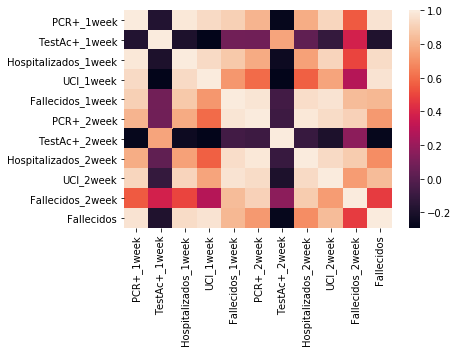

In [0]:
corr = df_week_analysis.corr()
sns.heatmap(corr, 
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values)

### Remove the bad correlation values

,FechaInicio_1week,PCR+_1week,Hospitalizados_1week,UCI_1week,Fallecidos_1week,PCR+_2week,Hospitalizados_2week,UCI_2week,Fallecidos_2week,Fallecidos,difference_deaths
0,0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,20-02-2020,2.571429,9.000000,0.428571,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,27-02-2020,47.571429,7.857143,0.571429,0.000000,2.571429,9.000000,0.428571,0.000000,12.142857,0.000000
3,05-03-2020,583.142857,210.142857,45.428571,12.142857,47.571429,7.857143,0.571429,0.000000,97.285714,12.142857
4,12-03-2020,2473.000000,1053.714286,186.571429,97.285714,583.142857,210.142857,45.428571,12.142857,450.571429,85.142857
5,19-03-2020,6392.571429,3538.000000,414.714286,450.571429,2473.000000,1053.714286,186.571429,97.285714,803.714286,353.285714
6,26-03-2020,7546.571429,4689.142857,352.285714,803.714286,6392.571429,3538.000000,414.714286,450.571429,744.857143,353.142857
7,02-04-2020,5677.285714,2783.857143,236.142857,744.857143,7546.571429,4689.142857,352.285714,803.714286,591.571429,-58.857143
8,09-04-2020,3958.571429,1953.285714,135.142857,591.571429,5677.285714,2783.857143,236.142857,744.857143,465.000000,-153.285714
9,16-04-2020,2995.571429,1316.714286,84.428571,465.000000,3958.571429,1953.285714,135.142857,591.571429,340.142857,-126.571429


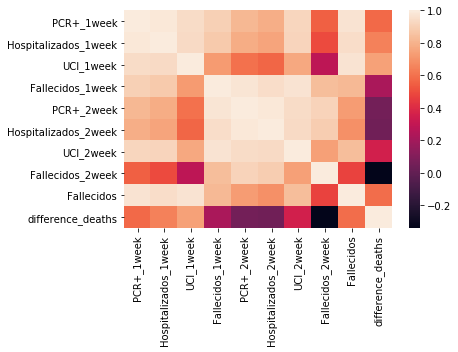

In [0]:
del df_week_analysis['TestAc+_2week']
del df_week_analysis['TestAc+_1week']
del df_week_analysis["FechaInicio_2week"]
#we add a value with the delta of deaths at week1 and week 2
df_week_analysis['difference_deaths'] = df_week_analysis['Fallecidos_1week'] - df_week_analysis['Fallecidos_2week']
corr = df_week_analysis.corr()
sns.heatmap(corr, 
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values)
df_week_analysis

### Linear Regression

In [0]:
#we train the model
Y = df_week_analysis.Fallecidos.values
X=np.column_stack([df_week_analysis[df_week_analysis.columns[2:11]].values])
X = np.delete(X, 7, 1) #(array, object, axis(1:col, 0:row)), removing fallecidos
size = int(len(X) * 0.66)
X_train, X_test, y_train, y_test = X[0:size], X[size:(len(X))],Y[0:size], Y[size:(len(Y))]
# Create model
linreg = LinearRegression()
linreg.fit(X_train, y_train)
# Calculate our y hat (how our model performs against the test data held off)
y_pred = linreg.predict(X_test)

'predicted'

[array([-655.3146705 , -593.6842984 , -703.29402411,  192.28696849,
         269.02427397])]

'real'

[array([465.        , 340.14285714, 217.85714286, 178.        ,
         90.28571429])]

the test MAE is: 633.6637042351563


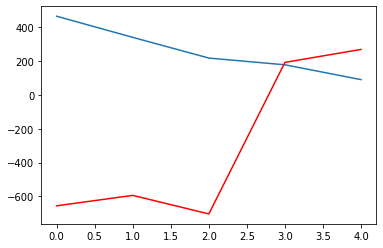

In [0]:
display("predicted",[y_pred], "real",[y_test])
from sklearn.metrics import mean_squared_error, mean_absolute_error
# See our Squared Mean Error score and Root Mean Squared Error:
test_mse = mean_squared_error(y_test, y_pred)
test_rmse = np.sqrt(test_mse)
# See our Mean Absolute Error
test_mae = mean_absolute_error(y_test, y_pred)
print(f"the test MAE is: {test_mae}")
pyplot.plot(y_test)
pyplot.plot(y_pred, color='red')
pyplot.show()

### Coefficients

In [0]:
#coef_ : array, shape (n_features, ) or (n_targets, n_features)
print("Coefficient for [Hospitalizados_1week 	UCI_1week 	Fallecidos_1week 	PCR+_2week 	Hospitalizados_2week 	UCI_2week 	Fallecidos_2week	difference_deaths ]")
print(linreg.coef_)

#intercept_ : array  Independent term in the linear model.

print(linreg.intercept_)

Coefficient for [Hospitalizados_1week 	UCI_1week 	Fallecidos_1week 	PCR+_2week 	Hospitalizados_2week 	UCI_2week 	Fallecidos_2week	difference_deaths ]
[-0.19133014  4.01793294  0.59168617 -1.2940216   1.25448894  7.90367053
  1.00641256 -0.41472639]
2.1032064978498966e-12


This time we added also a feature to relate the deaths of week t-1 and t-2 called "difference_deaths", it has a coefficient of -0,4 for the current linear regression

### Cross Validation

In [0]:
from sklearn.model_selection import cross_val_score
cv_4_results = cross_val_score(linreg, X, Y, cv=4, 
 scoring="neg_mean_absolute_error")
cv_4_results

array([  -41.49404552, -1301.49852807,  -107.92996616,  -794.89924592])

## Results of model 2
The model is not fitting  the data. The MAE is 633.66 which is terrible, and the cross validation has also enormous values too (they are very different). It might be caused by the low number of values of Y (only 12), which is the most probable option, or for an incorrect selection of features.

In [0]:
As we only have  12 points, we will consider to have more points separating the data for a week regionaly. Maybe if we do this, we should have a better model.

# Third Regression model
### Weekly dataframe separated by CCAA
Now let's work with the dataframe made at the beginning. It is daily and divided in CCAA.

In [0]:
regional_df.head(20) #WE HAVE 19 CCAA

,CCAA,FECHA,PCR+,TestAc+,Hospitalizados,UCI,Fallecidos
0,AN,20/2/2020,0,0.0,0.0,0.0,0.0
1,AR,20/2/2020,0,0.0,0.0,0.0,0.0
2,AS,20/2/2020,0,0.0,0.0,0.0,0.0
3,IB,20/2/2020,1,0.0,0.0,0.0,0.0
4,CN,20/2/2020,1,0.0,0.0,0.0,0.0
5,CB,20/2/2020,0,0.0,0.0,0.0,0.0
6,CM,20/2/2020,0,0.0,0.0,0.0,0.0
7,CL,20/2/2020,0,0.0,0.0,0.0,0.0
8,CT,20/2/2020,0,0.0,0.0,0.0,0.0
9,CE,20/2/2020,0,0.0,0.0,0.0,0.0


## New dataframe splitted in weeks
Let's apply the same methology that we did in the last model. Firstly, we are going to star with Andalucía CCAA (AN). We are going to sum values in groups of 7 in order to achieve the weekly df.

In [0]:
comunitat=regional_df[regional_df['CCAA']=='AN']
comunitat.reset_index(drop=True, inplace=True)
PCR=[]
TestAC=[]
Hospitalizados=[]
UCI=[]
Fallecidos=[]
FechaInicio=[]
Week=[]
index=0 #this will be the index for every day

#Creating the columns of the new dataframe:
for i in range(int(len(comunitat)/7)): #how many weeks we have information of?
    PCR=PCR+[comunitat.loc[index:index+6, 'PCR+'].sum()]
    TestAC=TestAC+[comunitat.loc[index:index+6, 'TestAc+'].sum()]
    Hospitalizados=Hospitalizados+[comunitat.loc[index:index+6, 'Hospitalizados'].sum()]
    UCI=UCI+[comunitat.loc[index:index+6, 'UCI'].sum()]
    Fallecidos=Fallecidos+[comunitat.loc[index:index+6, 'Fallecidos'].sum()]
    CCAA='AN'
    Week=Week+[i]
    #FechaInicio=FechaInicio+[comunitat.loc[index, 'FECHA']] ------- I don't know why it gives me problems :(
    index+=7 #next week

#From all these columns to a new dataframe:
data_dictionary={'Week': Week, 'CCAA': CCAA, 'PCR+': PCR, 'TestAc+': TestAC, 'Hospitalizados': Hospitalizados, 'UCI': UCI, 'Fallecidos': Fallecidos}
AN_weekly=pd.DataFrame(data_dictionary)
display(AN_weekly)

,Week,CCAA,PCR+,TestAc+,Hospitalizados,UCI,Fallecidos
0,0,AN,1,0.0,0.0,0.0,0.0
1,1,AN,11,0.0,0.0,0.0,0.0
2,2,AN,103,0.0,50.0,4.0,0.0
3,3,AN,893,0.0,334.0,21.0,23.0
4,4,AN,2396,0.0,1242.0,109.0,111.0
5,5,AN,3553,0.0,1818.0,146.0,209.0
6,6,AN,2277,0.0,1155.0,258.0,309.0
7,7,AN,1323,216.0,627.0,133.0,260.0
8,8,AN,801,621.0,390.0,31.0,167.0
9,9,AN,591,838.0,257.0,19.0,128.0


#### Now we will do the same for the rest of CCAAs

In [0]:
comunitat=regional_df[regional_df['CCAA']=='AR']
comunitat.reset_index(drop=True, inplace=True)
PCR=[]
TestAC=[]
Hospitalizados=[]
UCI=[]
Fallecidos=[]
FechaInicio=[]
Week=[]
index=0 #this will be the index for every day
#Creating the columns of the new dataframe:
for i in range(int(len(comunitat)/7)): #how many weeks we have information of?
    PCR=PCR+[comunitat.loc[index:index+6, 'PCR+'].sum()]
    TestAC=TestAC+[comunitat.loc[index:index+6, 'TestAc+'].sum()]
    Hospitalizados=Hospitalizados+[comunitat.loc[index:index+6, 'Hospitalizados'].sum()]
    UCI=UCI+[comunitat.loc[index:index+6, 'UCI'].sum()]
    Fallecidos=Fallecidos+[comunitat.loc[index:index+6, 'Fallecidos'].sum()]
    CCAA='AR'
    Week=Week+[i]
    #FechaInicio=FechaInicio+[comunitat.loc[index, 'FECHA']] ------- I don't know why it gives me problems :(
    index+=7 #next week
#From all these columns to a new dataframe:
data_dictionary={'Week': Week, 'CCAA': CCAA, 'PCR+': PCR, 'TestAc+': TestAC, 'Hospitalizados': Hospitalizados, 'UCI': UCI, 'Fallecidos': Fallecidos}
AR_weekly=pd.DataFrame(data_dictionary)
#########################################
comunitat=regional_df[regional_df['CCAA']=='AS']
comunitat.reset_index(drop=True, inplace=True)
PCR=[]
TestAC=[]
Hospitalizados=[]
UCI=[]
Fallecidos=[]
FechaInicio=[]
Week=[]
index=0 #this will be the index for every day
#Creating the columns of the new dataframe:
for i in range(int(len(comunitat)/7)): #how many weeks we have information of?
    PCR=PCR+[comunitat.loc[index:index+6, 'PCR+'].sum()]
    TestAC=TestAC+[comunitat.loc[index:index+6, 'TestAc+'].sum()]
    Hospitalizados=Hospitalizados+[comunitat.loc[index:index+6, 'Hospitalizados'].sum()]
    UCI=UCI+[comunitat.loc[index:index+6, 'UCI'].sum()]
    Fallecidos=Fallecidos+[comunitat.loc[index:index+6, 'Fallecidos'].sum()]
    CCAA='AS'
    Week=Week+[i]
    #FechaInicio=FechaInicio+[comunitat.loc[index, 'FECHA']] ------- I don't know why it gives me problems :(
    index+=7 #next week
#From all these columns to a new dataframe:
data_dictionary={'Week': Week, 'CCAA': CCAA, 'PCR+': PCR, 'TestAc+': TestAC, 'Hospitalizados': Hospitalizados, 'UCI': UCI, 'Fallecidos': Fallecidos}
AS_weekly=pd.DataFrame(data_dictionary)
#########################################
comunitat=regional_df[regional_df['CCAA']=='IB']
comunitat.reset_index(drop=True, inplace=True)
PCR=[]
TestAC=[]
Hospitalizados=[]
UCI=[]
Fallecidos=[]
FechaInicio=[]
Week=[]
index=0 #this will be the index for every day
#Creating the columns of the new dataframe:
for i in range(int(len(comunitat)/7)): #how many weeks we have information of?
    PCR=PCR+[comunitat.loc[index:index+6, 'PCR+'].sum()]
    TestAC=TestAC+[comunitat.loc[index:index+6, 'TestAc+'].sum()]
    Hospitalizados=Hospitalizados+[comunitat.loc[index:index+6, 'Hospitalizados'].sum()]
    UCI=UCI+[comunitat.loc[index:index+6, 'UCI'].sum()]
    Fallecidos=Fallecidos+[comunitat.loc[index:index+6, 'Fallecidos'].sum()]
    CCAA='IB'
    Week=Week+[i]
    #FechaInicio=FechaInicio+[comunitat.loc[index, 'FECHA']] ------- I don't know why it gives me problems :(
    index+=7 #next week
#From all these columns to a new dataframe:
data_dictionary={'Week': Week, 'CCAA': CCAA, 'PCR+': PCR, 'TestAc+': TestAC, 'Hospitalizados': Hospitalizados, 'UCI': UCI, 'Fallecidos': Fallecidos}
IB_weekly=pd.DataFrame(data_dictionary)
#########################################
comunitat=regional_df[regional_df['CCAA']=='CN']
comunitat.reset_index(drop=True, inplace=True)
PCR=[]
TestAC=[]
Hospitalizados=[]
UCI=[]
Fallecidos=[]
FechaInicio=[]
Week=[]
index=0 #this will be the index for every day
#Creating the columns of the new dataframe:
for i in range(int(len(comunitat)/7)): #how many weeks we have information of?
    PCR=PCR+[comunitat.loc[index:index+6, 'PCR+'].sum()]
    TestAC=TestAC+[comunitat.loc[index:index+6, 'TestAc+'].sum()]
    Hospitalizados=Hospitalizados+[comunitat.loc[index:index+6, 'Hospitalizados'].sum()]
    UCI=UCI+[comunitat.loc[index:index+6, 'UCI'].sum()]
    Fallecidos=Fallecidos+[comunitat.loc[index:index+6, 'Fallecidos'].sum()]
    CCAA='CN'
    Week=Week+[i]
    #FechaInicio=FechaInicio+[comunitat.loc[index, 'FECHA']] ------- I don't know why it gives me problems :(
    index+=7 #next week
#From all these columns to a new dataframe:
data_dictionary={'Week': Week, 'CCAA': CCAA, 'PCR+': PCR, 'TestAc+': TestAC, 'Hospitalizados': Hospitalizados, 'UCI': UCI, 'Fallecidos': Fallecidos}
CN_weekly=pd.DataFrame(data_dictionary)
#########################################
comunitat=regional_df[regional_df['CCAA']=='CB']
comunitat.reset_index(drop=True, inplace=True)
PCR=[]
TestAC=[]
Hospitalizados=[]
UCI=[]
Fallecidos=[]
FechaInicio=[]
Week=[]
index=0 #this will be the index for every day
#Creating the columns of the new dataframe:
for i in range(int(len(comunitat)/7)): #how many weeks we have information of?
    PCR=PCR+[comunitat.loc[index:index+6, 'PCR+'].sum()]
    TestAC=TestAC+[comunitat.loc[index:index+6, 'TestAc+'].sum()]
    Hospitalizados=Hospitalizados+[comunitat.loc[index:index+6, 'Hospitalizados'].sum()]
    UCI=UCI+[comunitat.loc[index:index+6, 'UCI'].sum()]
    Fallecidos=Fallecidos+[comunitat.loc[index:index+6, 'Fallecidos'].sum()]
    CCAA='CB'
    Week=Week+[i]
    #FechaInicio=FechaInicio+[comunitat.loc[index, 'FECHA']] ------- I don't know why it gives me problems :(
    index+=7 #next week
#From all these columns to a new dataframe:
data_dictionary={'Week': Week, 'CCAA': CCAA, 'PCR+': PCR, 'TestAc+': TestAC, 'Hospitalizados': Hospitalizados, 'UCI': UCI, 'Fallecidos': Fallecidos}
CB_weekly=pd.DataFrame(data_dictionary)
#########################################
comunitat=regional_df[regional_df['CCAA']=='CM']
comunitat.reset_index(drop=True, inplace=True)
PCR=[]
TestAC=[]
Hospitalizados=[]
UCI=[]
Fallecidos=[]
FechaInicio=[]
Week=[]
index=0 #this will be the index for every day
#Creating the columns of the new dataframe:
for i in range(int(len(comunitat)/7)): #how many weeks we have information of?
    PCR=PCR+[comunitat.loc[index:index+6, 'PCR+'].sum()]
    TestAC=TestAC+[comunitat.loc[index:index+6, 'TestAc+'].sum()]
    Hospitalizados=Hospitalizados+[comunitat.loc[index:index+6, 'Hospitalizados'].sum()]
    UCI=UCI+[comunitat.loc[index:index+6, 'UCI'].sum()]
    Fallecidos=Fallecidos+[comunitat.loc[index:index+6, 'Fallecidos'].sum()]
    CCAA='CM'
    Week=Week+[i]
    #FechaInicio=FechaInicio+[comunitat.loc[index, 'FECHA']] ------- I don't know why it gives me problems :(
    index+=7 #next week
#From all these columns to a new dataframe:
data_dictionary={'Week': Week, 'CCAA': CCAA, 'PCR+': PCR, 'TestAc+': TestAC, 'Hospitalizados': Hospitalizados, 'UCI': UCI, 'Fallecidos': Fallecidos}
CM_weekly=pd.DataFrame(data_dictionary)
#########################################
comunitat=regional_df[regional_df['CCAA']=='CL']
comunitat.reset_index(drop=True, inplace=True)
PCR=[]
TestAC=[]
Hospitalizados=[]
UCI=[]
Fallecidos=[]
FechaInicio=[]
Week=[]
index=0 #this will be the index for every day
#Creating the columns of the new dataframe:
for i in range(int(len(comunitat)/7)): #how many weeks we have information of?
    PCR=PCR+[comunitat.loc[index:index+6, 'PCR+'].sum()]
    TestAC=TestAC+[comunitat.loc[index:index+6, 'TestAc+'].sum()]
    Hospitalizados=Hospitalizados+[comunitat.loc[index:index+6, 'Hospitalizados'].sum()]
    UCI=UCI+[comunitat.loc[index:index+6, 'UCI'].sum()]
    Fallecidos=Fallecidos+[comunitat.loc[index:index+6, 'Fallecidos'].sum()]
    CCAA='CL'
    Week=Week+[i]
    #FechaInicio=FechaInicio+[comunitat.loc[index, 'FECHA']] ------- I don't know why it gives me problems :(
    index+=7 #next week
#From all these columns to a new dataframe:
data_dictionary={'Week': Week, 'CCAA': CCAA, 'PCR+': PCR, 'TestAc+': TestAC, 'Hospitalizados': Hospitalizados, 'UCI': UCI, 'Fallecidos': Fallecidos}
CL_weekly=pd.DataFrame(data_dictionary)
#########################################
comunitat=regional_df[regional_df['CCAA']=='CT']
comunitat.reset_index(drop=True, inplace=True)
PCR=[]
TestAC=[]
Hospitalizados=[]
UCI=[]
Fallecidos=[]
FechaInicio=[]
Week=[]
index=0 #this will be the index for every day
#Creating the columns of the new dataframe:
for i in range(int(len(comunitat)/7)): #how many weeks we have information of?
    PCR=PCR+[comunitat.loc[index:index+6, 'PCR+'].sum()]
    TestAC=TestAC+[comunitat.loc[index:index+6, 'TestAc+'].sum()]
    Hospitalizados=Hospitalizados+[comunitat.loc[index:index+6, 'Hospitalizados'].sum()]
    UCI=UCI+[comunitat.loc[index:index+6, 'UCI'].sum()]
    Fallecidos=Fallecidos+[comunitat.loc[index:index+6, 'Fallecidos'].sum()]
    CCAA='CT'
    Week=Week+[i]
    #FechaInicio=FechaInicio+[comunitat.loc[index, 'FECHA']] ------- I don't know why it gives me problems :(
    index+=7 #next week
#From all these columns to a new dataframe:
data_dictionary={'Week': Week, 'CCAA': CCAA, 'PCR+': PCR, 'TestAc+': TestAC, 'Hospitalizados': Hospitalizados, 'UCI': UCI, 'Fallecidos': Fallecidos}
CT_weekly=pd.DataFrame(data_dictionary)
#########################################
comunitat=regional_df[regional_df['CCAA']=='CE']
comunitat.reset_index(drop=True, inplace=True)
PCR=[]
TestAC=[]
Hospitalizados=[]
UCI=[]
Fallecidos=[]
FechaInicio=[]
Week=[]
index=0 #this will be the index for every day
#Creating the columns of the new dataframe:
for i in range(int(len(comunitat)/7)): #how many weeks we have information of?
    PCR=PCR+[comunitat.loc[index:index+6, 'PCR+'].sum()]
    TestAC=TestAC+[comunitat.loc[index:index+6, 'TestAc+'].sum()]
    Hospitalizados=Hospitalizados+[comunitat.loc[index:index+6, 'Hospitalizados'].sum()]
    UCI=UCI+[comunitat.loc[index:index+6, 'UCI'].sum()]
    Fallecidos=Fallecidos+[comunitat.loc[index:index+6, 'Fallecidos'].sum()]
    CCAA='CE'
    Week=Week+[i]
    #FechaInicio=FechaInicio+[comunitat.loc[index, 'FECHA']] ------- I don't know why it gives me problems :(
    index+=7 #next week
#From all these columns to a new dataframe:
data_dictionary={'Week': Week, 'CCAA': CCAA, 'PCR+': PCR, 'TestAc+': TestAC, 'Hospitalizados': Hospitalizados, 'UCI': UCI, 'Fallecidos': Fallecidos}
CE_weekly=pd.DataFrame(data_dictionary)
#########################################
comunitat=regional_df[regional_df['CCAA']=='VC']
comunitat.reset_index(drop=True, inplace=True)
PCR=[]
TestAC=[]
Hospitalizados=[]
UCI=[]
Fallecidos=[]
FechaInicio=[]
Week=[]
index=0 #this will be the index for every day
#Creating the columns of the new dataframe:
for i in range(int(len(comunitat)/7)): #how many weeks we have information of?
    PCR=PCR+[comunitat.loc[index:index+6, 'PCR+'].sum()]
    TestAC=TestAC+[comunitat.loc[index:index+6, 'TestAc+'].sum()]
    Hospitalizados=Hospitalizados+[comunitat.loc[index:index+6, 'Hospitalizados'].sum()]
    UCI=UCI+[comunitat.loc[index:index+6, 'UCI'].sum()]
    Fallecidos=Fallecidos+[comunitat.loc[index:index+6, 'Fallecidos'].sum()]
    CCAA='VC'
    Week=Week+[i]
    #FechaInicio=FechaInicio+[comunitat.loc[index, 'FECHA']] ------- I don't know why it gives me problems :(
    index+=7 #next week
#From all these columns to a new dataframe:
data_dictionary={'Week': Week, 'CCAA': CCAA, 'PCR+': PCR, 'TestAc+': TestAC, 'Hospitalizados': Hospitalizados, 'UCI': UCI, 'Fallecidos': Fallecidos}
VC_weekly=pd.DataFrame(data_dictionary)
#########################################
comunitat=regional_df[regional_df['CCAA']=='EX']
comunitat.reset_index(drop=True, inplace=True)
PCR=[]
TestAC=[]
Hospitalizados=[]
UCI=[]
Fallecidos=[]
FechaInicio=[]
Week=[]
index=0 #this will be the index for every day
#Creating the columns of the new dataframe:
for i in range(int(len(comunitat)/7)): #how many weeks we have information of?
    PCR=PCR+[comunitat.loc[index:index+6, 'PCR+'].sum()]
    TestAC=TestAC+[comunitat.loc[index:index+6, 'TestAc+'].sum()]
    Hospitalizados=Hospitalizados+[comunitat.loc[index:index+6, 'Hospitalizados'].sum()]
    UCI=UCI+[comunitat.loc[index:index+6, 'UCI'].sum()]
    Fallecidos=Fallecidos+[comunitat.loc[index:index+6, 'Fallecidos'].sum()]
    CCAA='EX'
    Week=Week+[i]
    #FechaInicio=FechaInicio+[comunitat.loc[index, 'FECHA']] ------- I don't know why it gives me problems :(
    index+=7 #next week
#From all these columns to a new dataframe:
data_dictionary={'Week': Week, 'CCAA': CCAA, 'PCR+': PCR, 'TestAc+': TestAC, 'Hospitalizados': Hospitalizados, 'UCI': UCI, 'Fallecidos': Fallecidos}
EX_weekly=pd.DataFrame(data_dictionary)
#########################################
comunitat=regional_df[regional_df['CCAA']=='GA']
comunitat.reset_index(drop=True, inplace=True)
PCR=[]
TestAC=[]
Hospitalizados=[]
UCI=[]
Fallecidos=[]
FechaInicio=[]
Week=[]
index=0 #this will be the index for every day
#Creating the columns of the new dataframe:
for i in range(int(len(comunitat)/7)): #how many weeks we have information of?
    PCR=PCR+[comunitat.loc[index:index+6, 'PCR+'].sum()]
    TestAC=TestAC+[comunitat.loc[index:index+6, 'TestAc+'].sum()]
    Hospitalizados=Hospitalizados+[comunitat.loc[index:index+6, 'Hospitalizados'].sum()]
    UCI=UCI+[comunitat.loc[index:index+6, 'UCI'].sum()]
    Fallecidos=Fallecidos+[comunitat.loc[index:index+6, 'Fallecidos'].sum()]
    CCAA='GA'
    Week=Week+[i]
    #FechaInicio=FechaInicio+[comunitat.loc[index, 'FECHA']] ------- I don't know why it gives me problems :(
    index+=7 #next week
#From all these columns to a new dataframe:
data_dictionary={'Week': Week, 'CCAA': CCAA, 'PCR+': PCR, 'TestAc+': TestAC, 'Hospitalizados': Hospitalizados, 'UCI': UCI, 'Fallecidos': Fallecidos}
GA_weekly=pd.DataFrame(data_dictionary)
#########################################
comunitat=regional_df[regional_df['CCAA']=='MD']
comunitat.reset_index(drop=True, inplace=True)
PCR=[]
TestAC=[]
Hospitalizados=[]
UCI=[]
Fallecidos=[]
FechaInicio=[]
Week=[]
index=0 #this will be the index for every day
#Creating the columns of the new dataframe:
for i in range(int(len(comunitat)/7)): #how many weeks we have information of?
    PCR=PCR+[comunitat.loc[index:index+6, 'PCR+'].sum()]
    TestAC=TestAC+[comunitat.loc[index:index+6, 'TestAc+'].sum()]
    Hospitalizados=Hospitalizados+[comunitat.loc[index:index+6, 'Hospitalizados'].sum()]
    UCI=UCI+[comunitat.loc[index:index+6, 'UCI'].sum()]
    Fallecidos=Fallecidos+[comunitat.loc[index:index+6, 'Fallecidos'].sum()]
    CCAA='MD'
    Week=Week+[i]
    #FechaInicio=FechaInicio+[comunitat.loc[index, 'FECHA']] ------- I don't know why it gives me problems :(
    index+=7 #next week
#From all these columns to a new dataframe:
data_dictionary={'Week': Week, 'CCAA': CCAA, 'PCR+': PCR, 'TestAc+': TestAC, 'Hospitalizados': Hospitalizados, 'UCI': UCI, 'Fallecidos': Fallecidos}
MD_weekly=pd.DataFrame(data_dictionary)
#########################################
comunitat=regional_df[regional_df['CCAA']=='ML']
comunitat.reset_index(drop=True, inplace=True)
PCR=[]
TestAC=[]
Hospitalizados=[]
UCI=[]
Fallecidos=[]
FechaInicio=[]
Week=[]
index=0 #this will be the index for every day
#Creating the columns of the new dataframe:
for i in range(int(len(comunitat)/7)): #how many weeks we have information of?
    PCR=PCR+[comunitat.loc[index:index+6, 'PCR+'].sum()]
    TestAC=TestAC+[comunitat.loc[index:index+6, 'TestAc+'].sum()]
    Hospitalizados=Hospitalizados+[comunitat.loc[index:index+6, 'Hospitalizados'].sum()]
    UCI=UCI+[comunitat.loc[index:index+6, 'UCI'].sum()]
    Fallecidos=Fallecidos+[comunitat.loc[index:index+6, 'Fallecidos'].sum()]
    CCAA='ML'
    Week=Week+[i]
    #FechaInicio=FechaInicio+[comunitat.loc[index, 'FECHA']] ------- I don't know why it gives me problems :(
    index+=7 #next week
#From all these columns to a new dataframe:
data_dictionary={'Week': Week, 'CCAA': CCAA, 'PCR+': PCR, 'TestAc+': TestAC, 'Hospitalizados': Hospitalizados, 'UCI': UCI, 'Fallecidos': Fallecidos}
ML_weekly=pd.DataFrame(data_dictionary)
#########################################
comunitat=regional_df[regional_df['CCAA']=='MC']
comunitat.reset_index(drop=True, inplace=True)
PCR=[]
TestAC=[]
Hospitalizados=[]
UCI=[]
Fallecidos=[]
FechaInicio=[]
Week=[]
index=0 #this will be the index for every day
#Creating the columns of the new dataframe:
for i in range(int(len(comunitat)/7)): #how many weeks we have information of?
    PCR=PCR+[comunitat.loc[index:index+6, 'PCR+'].sum()]
    TestAC=TestAC+[comunitat.loc[index:index+6, 'TestAc+'].sum()]
    Hospitalizados=Hospitalizados+[comunitat.loc[index:index+6, 'Hospitalizados'].sum()]
    UCI=UCI+[comunitat.loc[index:index+6, 'UCI'].sum()]
    Fallecidos=Fallecidos+[comunitat.loc[index:index+6, 'Fallecidos'].sum()]
    CCAA='MC'
    Week=Week+[i]
    #FechaInicio=FechaInicio+[comunitat.loc[index, 'FECHA']] ------- I don't know why it gives me problems :(
    index+=7 #next week
#From all these columns to a new dataframe:
data_dictionary={'Week': Week, 'CCAA': CCAA, 'PCR+': PCR, 'TestAc+': TestAC, 'Hospitalizados': Hospitalizados, 'UCI': UCI, 'Fallecidos': Fallecidos}
MC_weekly=pd.DataFrame(data_dictionary)
#########################################
comunitat=regional_df[regional_df['CCAA']=='NC']
comunitat.reset_index(drop=True, inplace=True)
PCR=[]
TestAC=[]
Hospitalizados=[]
UCI=[]
Fallecidos=[]
FechaInicio=[]
Week=[]
index=0 #this will be the index for every day
#Creating the columns of the new dataframe:
for i in range(int(len(comunitat)/7)): #how many weeks we have information of?
    PCR=PCR+[comunitat.loc[index:index+6, 'PCR+'].sum()]
    TestAC=TestAC+[comunitat.loc[index:index+6, 'TestAc+'].sum()]
    Hospitalizados=Hospitalizados+[comunitat.loc[index:index+6, 'Hospitalizados'].sum()]
    UCI=UCI+[comunitat.loc[index:index+6, 'UCI'].sum()]
    Fallecidos=Fallecidos+[comunitat.loc[index:index+6, 'Fallecidos'].sum()]
    CCAA='NC'
    Week=Week+[i]
    #FechaInicio=FechaInicio+[comunitat.loc[index, 'FECHA']] ------- I don't know why it gives me problems :(
    index+=7 #next week
#From all these columns to a new dataframe:
data_dictionary={'Week': Week, 'CCAA': CCAA, 'PCR+': PCR, 'TestAc+': TestAC, 'Hospitalizados': Hospitalizados, 'UCI': UCI, 'Fallecidos': Fallecidos}
NC_weekly=pd.DataFrame(data_dictionary)
#########################################
comunitat=regional_df[regional_df['CCAA']=='PV']
comunitat.reset_index(drop=True, inplace=True)
PCR=[]
TestAC=[]
Hospitalizados=[]
UCI=[]
Fallecidos=[]
FechaInicio=[]
Week=[]
index=0 #this will be the index for every day
#Creating the columns of the new dataframe:
for i in range(int(len(comunitat)/7)): #how many weeks we have information of?
    PCR=PCR+[comunitat.loc[index:index+6, 'PCR+'].sum()]
    TestAC=TestAC+[comunitat.loc[index:index+6, 'TestAc+'].sum()]
    Hospitalizados=Hospitalizados+[comunitat.loc[index:index+6, 'Hospitalizados'].sum()]
    UCI=UCI+[comunitat.loc[index:index+6, 'UCI'].sum()]
    Fallecidos=Fallecidos+[comunitat.loc[index:index+6, 'Fallecidos'].sum()]
    CCAA='PV'
    Week=Week+[i]
    #FechaInicio=FechaInicio+[comunitat.loc[index, 'FECHA']] ------- I don't know why it gives me problems :(
    index+=7 #next week
#From all these columns to a new dataframe:
data_dictionary={'Week': Week, 'CCAA': CCAA, 'PCR+': PCR, 'TestAc+': TestAC, 'Hospitalizados': Hospitalizados, 'UCI': UCI, 'Fallecidos': Fallecidos}
PV_weekly=pd.DataFrame(data_dictionary)
#########################################
comunitat=regional_df[regional_df['CCAA']=='RI']
comunitat.reset_index(drop=True, inplace=True)
PCR=[]
TestAC=[]
Hospitalizados=[]
UCI=[]
Fallecidos=[]
FechaInicio=[]
Week=[]
index=0 #this will be the index for every day
#Creating the columns of the new dataframe:
for i in range(int(len(comunitat)/7)): #how many weeks we have information of?
    PCR=PCR+[comunitat.loc[index:index+6, 'PCR+'].sum()]
    TestAC=TestAC+[comunitat.loc[index:index+6, 'TestAc+'].sum()]
    Hospitalizados=Hospitalizados+[comunitat.loc[index:index+6, 'Hospitalizados'].sum()]
    UCI=UCI+[comunitat.loc[index:index+6, 'UCI'].sum()]
    Fallecidos=Fallecidos+[comunitat.loc[index:index+6, 'Fallecidos'].sum()]
    CCAA='RI'
    Week=Week+[i]
    #FechaInicio=FechaInicio+[comunitat.loc[index, 'FECHA']] ------- I don't know why it gives me problems :(
    index+=7 #next week
#From all these columns to a new dataframe:
data_dictionary={'Week': Week, 'CCAA': CCAA, 'PCR+': PCR, 'TestAc+': TestAC, 'Hospitalizados': Hospitalizados, 'UCI': UCI, 'Fallecidos': Fallecidos}
RI_weekly=pd.DataFrame(data_dictionary)

## The New Df splitted in weeks and CCAAs is ready

In [0]:
#Mergin CCAA datframes
weekly_CCAA=[AN_weekly, AR_weekly, AS_weekly, IB_weekly, CN_weekly, CB_weekly, CM_weekly, CL_weekly, CT_weekly, CE_weekly, VC_weekly, EX_weekly, GA_weekly, MD_weekly, ML_weekly, MC_weekly, NC_weekly, PV_weekly, RI_weekly]
weekly_CCAA = pd.concat(weekly_CCAA)
weekly_CCAA.reset_index(drop=True, inplace=True)
weekly_CCAA.head(20)

,Week,CCAA,PCR+,TestAc+,Hospitalizados,UCI,Fallecidos
0,0,AN,1,0.0,0.0,0.0,0.0
1,1,AN,11,0.0,0.0,0.0,0.0
2,2,AN,103,0.0,50.0,4.0,0.0
3,3,AN,893,0.0,334.0,21.0,23.0
4,4,AN,2396,0.0,1242.0,109.0,111.0
5,5,AN,3553,0.0,1818.0,146.0,209.0
6,6,AN,2277,0.0,1155.0,258.0,309.0
7,7,AN,1323,216.0,627.0,133.0,260.0
8,8,AN,801,621.0,390.0,31.0,167.0
9,9,AN,591,838.0,257.0,19.0,128.0


### A New Modification
We are going to sum the values of PCR+ and TestAc+, because they are strongly correlated between them and it will be better working with one column rather than two. We will call them **Diagnosed**

In [0]:
Diagnosed=[]
for i in range(len(weekly_CCAA)): 
    Diagnosed=Diagnosed+[weekly_CCAA.loc[i, 'PCR+']+weekly_CCAA.loc[i, 'TestAc+']]
weekly_CCAA['Diagnosed']=Diagnosed
display(weekly_CCAA)

,Week,CCAA,PCR+,TestAc+,Hospitalizados,UCI,Fallecidos,Diagnosed
0,0,AN,1,0.0,0.0,0.0,0.0,1.0
1,1,AN,11,0.0,0.0,0.0,0.0,11.0
2,2,AN,103,0.0,50.0,4.0,0.0,103.0
3,3,AN,893,0.0,334.0,21.0,23.0,893.0
4,4,AN,2396,0.0,1242.0,109.0,111.0,2396.0
...,...,...,...,...,...,...,...,...
242,8,RI,202,609.0,124.0,7.0,46.0,811.0
243,9,RI,177,302.0,93.0,6.0,29.0,479.0
244,10,RI,68,56.0,39.0,3.0,6.0,124.0
245,11,RI,28,47.0,21.0,0.0,10.0,75.0


### Creation of t-1 and t-2 DataFrame
The first weeks are filled with 0. For that reason we will divide them by 3 in order to obtain less weeks with 0. We do that because otherwise the model will be afected by too much presence of 0's at the beginning.

In [0]:
########################  1 week ago  ######################################################
Diagnosed_oneago=[]
Deaths_oneago=[]
Hosp_oneago=[]
UCI_oneago=[]

for i in range(len(weekly_CCAA)): 
    if(weekly_CCAA.loc[i, 'Week']==0):
        Diagnosed_oneago=Diagnosed_oneago+[weekly_CCAA.loc[i, 'Diagnosed']/3] #for the first week we do not have information from the week before
        Deaths_oneago=Deaths_oneago+[weekly_CCAA.loc[i, 'Fallecidos']/3]
        Hosp_oneago=Hosp_oneago+[weekly_CCAA.loc[i, 'Hospitalizados']/3]
        UCI_oneago=UCI_oneago+[weekly_CCAA.loc[i, 'UCI']/3]
    else:
        Diagnosed_oneago=Diagnosed_oneago+[weekly_CCAA.loc[i-1, 'Diagnosed']]
        Deaths_oneago=Deaths_oneago+[weekly_CCAA.loc[i-1, 'Fallecidos']]
        Hosp_oneago=Hosp_oneago+[weekly_CCAA.loc[i-1, 'Hospitalizados']]
        UCI_oneago=UCI_oneago+[weekly_CCAA.loc[i-1, 'UCI']]
        
weekly_CCAA['Diagnosed 1 week ago']=Diagnosed_oneago
weekly_CCAA['Fallecidos 1 week ago']=Deaths_oneago
weekly_CCAA['Hospitalizados 1 week ago']=Hosp_oneago
weekly_CCAA['UCI 1 week ago']=UCI_oneago

########################  2 weeks ago  ######################################################
Diagnosed_2ago=[]
Deaths_2ago=[]
Hosp_2ago=[]
UCI_2ago=[]

for i in range(len(weekly_CCAA)): 
    if(weekly_CCAA.loc[i, 'Week']==0):
        Diagnosed_2ago=Diagnosed_2ago+[weekly_CCAA.loc[i, 'Diagnosed 1 week ago']/3] 
        Deaths_2ago=Deaths_2ago+[weekly_CCAA.loc[i, 'Fallecidos 1 week ago']/3]
        Hosp_2ago=Hosp_2ago+[weekly_CCAA.loc[i, 'Hospitalizados 1 week ago']/3]
        UCI_2ago=UCI_2ago+[weekly_CCAA.loc[i, 'UCI 1 week ago']/3]
    elif (weekly_CCAA.loc[i, 'Week']==1):
        Diagnosed_2ago=Diagnosed_2ago+[weekly_CCAA.loc[i, 'Diagnosed 1 week ago']] 
        Deaths_2ago=Deaths_2ago+[weekly_CCAA.loc[i, 'Fallecidos 1 week ago']]
        Hosp_2ago=Hosp_2ago+[weekly_CCAA.loc[i, 'Hospitalizados 1 week ago']]
        UCI_2ago=UCI_2ago+[weekly_CCAA.loc[i, 'UCI 1 week ago']]
    else:
        Diagnosed_2ago=Diagnosed_2ago+[weekly_CCAA.loc[i-2, 'Diagnosed']]
        Deaths_2ago=Deaths_2ago+[weekly_CCAA.loc[i-2, 'Fallecidos']]
        Hosp_2ago=Hosp_2ago+[weekly_CCAA.loc[i-2, 'Hospitalizados']]
        UCI_2ago=UCI_2ago+[weekly_CCAA.loc[i-2, 'UCI']]
        
weekly_CCAA['Diagnosed 2 weeks ago']=Diagnosed_2ago
weekly_CCAA['Fallecidos 2 weeks ago']=Deaths_2ago
weekly_CCAA['Hospitalizados 2 weeks ago']=Hosp_2ago
weekly_CCAA['UCI 2 weeks ago']=UCI_2ago

weekly_CCAA.head(20)

,Week,CCAA,PCR+,TestAc+,Hospitalizados,UCI,Fallecidos,Diagnosed,Diagnosed 1 week ago,Fallecidos 1 week ago,Hospitalizados 1 week ago,UCI 1 week ago,Diagnosed 2 weeks ago,Fallecidos 2 weeks ago,Hospitalizados 2 weeks ago,UCI 2 weeks ago
0,0,AN,1,0.0,0.0,0.0,0.0,1.0,0.333333,0.0,0.0,0.0,0.111111,0.0,0.0,0.0
1,1,AN,11,0.0,0.0,0.0,0.0,11.0,1.000000,0.0,0.0,0.0,1.000000,0.0,0.0,0.0
2,2,AN,103,0.0,50.0,4.0,0.0,103.0,11.000000,0.0,0.0,0.0,1.000000,0.0,0.0,0.0
3,3,AN,893,0.0,334.0,21.0,23.0,893.0,103.000000,0.0,50.0,4.0,11.000000,0.0,0.0,0.0
4,4,AN,2396,0.0,1242.0,109.0,111.0,2396.0,893.000000,23.0,334.0,21.0,103.000000,0.0,50.0,4.0
5,5,AN,3553,0.0,1818.0,146.0,209.0,3553.0,2396.000000,111.0,1242.0,109.0,893.000000,23.0,334.0,21.0
6,6,AN,2277,0.0,1155.0,258.0,309.0,2277.0,3553.000000,209.0,1818.0,146.0,2396.000000,111.0,1242.0,109.0
7,7,AN,1323,216.0,627.0,133.0,260.0,1539.0,2277.000000,309.0,1155.0,258.0,3553.000000,209.0,1818.0,146.0
8,8,AN,801,621.0,390.0,31.0,167.0,1422.0,1539.000000,260.0,627.0,133.0,2277.000000,309.0,1155.0,258.0
9,9,AN,591,838.0,257.0,19.0,128.0,1429.0,1422.000000,167.0,390.0,31.0,1539.000000,260.0,627.0,133.0


### Correlation between t, t-1 and t-2
being t equal to a week.

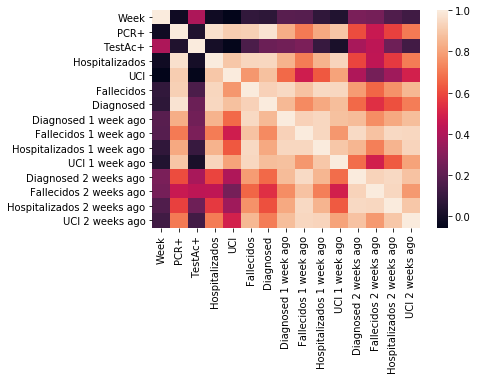

In [0]:
corr = weekly_CCAA.corr()
sns.heatmap(corr, 
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values)

### Linear Regression

In [0]:
#we train the model
Y = weekly_CCAA.Fallecidos.values
X=np.column_stack([weekly_CCAA[weekly_CCAA.columns[8:16]].values])
size = int(len(X) * 0.66)
X_train, X_test, y_train, y_test = X[0:size], X[size:(len(X))],Y[0:size], Y[size:(len(Y))]
# Create model
linreg = LinearRegression()
linreg.fit(X_train, y_train)
# Calculate our y hat (how our model performs against the test data held off)
y_pred = linreg.predict(X_test)


the test MAE is: 31.637658835538836


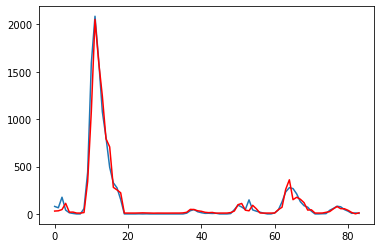

In [0]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
# See our Squared Mean Error score and Root Mean Squared Error:
test_mse = mean_squared_error(y_test, y_pred)
test_rmse = np.sqrt(test_mse)
# See our Mean Absolute Error
test_mae = mean_absolute_error(y_test, y_pred)
print(f"the test MAE is: {test_mae}")
pyplot.plot(y_test)
pyplot.plot(y_pred, color='red')
pyplot.show()

### Coefficients

In [0]:
#coef_ : array, shape (n_features, ) or (n_targets, n_features)
print("Coefficient for [Diagnosed 1 week ago 	Fallecidos 1 week ago 	Hospitalizados 1 week ago 	UCI 1 week ago 	Diagnosed 2 weeks ago 	Fallecidos 2 weeks ago 	Hospitalizados 2 weeks ago 	UCI 2 weeks ago ]")
print(linreg.coef_)

#intercept_ : array  Independent term in the linear model.

print(linreg.intercept_)

Coefficient for [Diagnosed 1 week ago 	Fallecidos 1 week ago 	Hospitalizados 1 week ago 	UCI 1 week ago 	Diagnosed 2 weeks ago 	Fallecidos 2 weeks ago 	Hospitalizados 2 weeks ago 	UCI 2 weeks ago ]
[ 0.02852247  0.47829372  0.05277375  0.80499927 -0.04687636  0.21195216
  0.0008402  -0.39589421]
8.946645944487756


### Cross Validation

In [0]:
from sklearn.model_selection import cross_val_score
cv_4_results = cross_val_score(linreg, X, Y, cv=4, 
 scoring="neg_mean_absolute_error")
cv_4_results

array([-17.27886113, -46.17209505, -37.50728954, -17.83481684])

## Results
The results of model 3 are really good compared to the other ones. The model has got a MAE of 31.63 which is good. Even so, the crossvalidation has variance of results, so maybe we should apply new changes to this model in order to improve it.

# Fourth Regression model
### Removing the first weeks zeros &  setting Logarithmic values for deaths
We are going to remove the first weeks in order to remove the **zeros**, because these values are really **easy to predict**. When we have got a zero it's easy to predict that the next day a zero will show up. So, we will create a new dataframe that will be used to train the model. As we have got the number of each week (for every region), what we need to do, is to remove the first 3 weeks (for example).

After that, since there are **large differences** between the weeks of the number of deaths, we have decided to apply the **logarithmic scale.**

### Removing 0's

In [0]:
CCAA_Weeks=weekly_CCAA
CCAA_Weeks.drop(CCAA_Weeks[CCAA_Weeks['Fallecidos'] == 0 ].index , inplace=True)
CCAA_Weeks.drop(CCAA_Weeks[CCAA_Weeks['Fallecidos 1 week ago'] == 0 ].index , inplace=True)
CCAA_Weeks.drop(CCAA_Weeks[CCAA_Weeks['Fallecidos 2 weeks ago'] == 0 ].index , inplace=True)
CCAA_Weeks.reset_index(drop=True, inplace=True) #reset the index
CCAA_Weeks

,Week,CCAA,PCR+,TestAc+,Hospitalizados,UCI,Fallecidos,Diagnosed,Diagnosed 1 week ago,Fallecidos 1 week ago,Hospitalizados 1 week ago,UCI 1 week ago,Diagnosed 2 weeks ago,Fallecidos 2 weeks ago,Hospitalizados 2 weeks ago,UCI 2 weeks ago
0,5,AN,3553,0.0,1818.0,146.0,209.0,3553.0,2396.0,111.0,1242.0,109.0,893.0,23.0,334.0,21.0
1,6,AN,2277,0.0,1155.0,258.0,309.0,2277.0,3553.0,209.0,1818.0,146.0,2396.0,111.0,1242.0,109.0
2,7,AN,1323,216.0,627.0,133.0,260.0,1539.0,2277.0,309.0,1155.0,258.0,3553.0,209.0,1818.0,146.0
3,8,AN,801,621.0,390.0,31.0,167.0,1422.0,1539.0,260.0,627.0,133.0,2277.0,309.0,1155.0,258.0
4,9,AN,591,838.0,257.0,19.0,128.0,1429.0,1422.0,167.0,390.0,31.0,1539.0,260.0,627.0,133.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
139,8,RI,202,609.0,124.0,7.0,46.0,811.0,890.0,75.0,210.0,6.0,943.0,81.0,337.0,12.0
140,9,RI,177,302.0,93.0,6.0,29.0,479.0,811.0,46.0,124.0,7.0,890.0,75.0,210.0,6.0
141,10,RI,68,56.0,39.0,3.0,6.0,124.0,479.0,29.0,93.0,6.0,811.0,46.0,124.0,7.0
142,11,RI,28,47.0,21.0,0.0,10.0,75.0,124.0,6.0,39.0,3.0,479.0,29.0,93.0,6.0


### Logarithmic values for deaths

In [0]:
# use this method to test if we reduce the error without overfitting our model.
#We apply the .log in the values of the fallecidos because they are what we are interested in predicting
CCAA_Weeks["Fallecidos_log"] = np.log(CCAA_Weeks['Fallecidos']) #natural log (ln)
CCAA_Weeks["Fallecidos 1 week ago_log"] = np.log(CCAA_Weeks['Fallecidos 1 week ago'])
CCAA_Weeks["Fallecidos 2 weeks ago_log"] = np.log(CCAA_Weeks['Fallecidos 2 weeks ago'])

CCAA_Weeks["Fallecidos"] = CCAA_Weeks['Fallecidos_log']
CCAA_Weeks["Fallecidos 1 week ago"] = CCAA_Weeks['Fallecidos 1 week ago_log']
CCAA_Weeks["Fallecidos 2 weeks ago"] = CCAA_Weeks['Fallecidos 2 weeks ago_log']

CCAA_Weeks.drop(['Fallecidos_log', 'Fallecidos 1 week ago_log', 'Fallecidos 2 weeks ago_log'], axis=1, inplace=True)
display(CCAA_Weeks)

,Week,CCAA,PCR+,TestAc+,Hospitalizados,UCI,Fallecidos,Diagnosed,Diagnosed 1 week ago,Fallecidos 1 week ago,Hospitalizados 1 week ago,UCI 1 week ago,Diagnosed 2 weeks ago,Fallecidos 2 weeks ago,Hospitalizados 2 weeks ago,UCI 2 weeks ago
0,5,AN,3553,0.0,1818.0,146.0,5.342334,3553.0,2396.0,4.709530,1242.0,109.0,893.0,3.135494,334.0,21.0
1,6,AN,2277,0.0,1155.0,258.0,5.733341,2277.0,3553.0,5.342334,1818.0,146.0,2396.0,4.709530,1242.0,109.0
2,7,AN,1323,216.0,627.0,133.0,5.560682,1539.0,2277.0,5.733341,1155.0,258.0,3553.0,5.342334,1818.0,146.0
3,8,AN,801,621.0,390.0,31.0,5.117994,1422.0,1539.0,5.560682,627.0,133.0,2277.0,5.733341,1155.0,258.0
4,9,AN,591,838.0,257.0,19.0,4.852030,1429.0,1422.0,5.117994,390.0,31.0,1539.0,5.560682,627.0,133.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
139,8,RI,202,609.0,124.0,7.0,3.828641,811.0,890.0,4.317488,210.0,6.0,943.0,4.394449,337.0,12.0
140,9,RI,177,302.0,93.0,6.0,3.367296,479.0,811.0,3.828641,124.0,7.0,890.0,4.317488,210.0,6.0
141,10,RI,68,56.0,39.0,3.0,1.791759,124.0,479.0,3.367296,93.0,6.0,811.0,3.828641,124.0,7.0
142,11,RI,28,47.0,21.0,0.0,2.302585,75.0,124.0,1.791759,39.0,3.0,479.0,3.367296,93.0,6.0


### Correlation

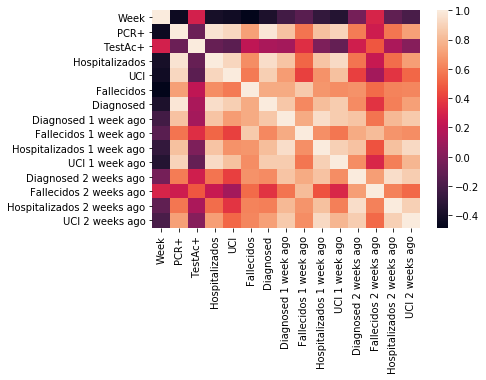

In [0]:
corr = CCAA_Weeks.corr()
sns.heatmap(corr, 
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values)

### Linear Regression & Cross Validation

the test MAE is: 0.5030065726374879


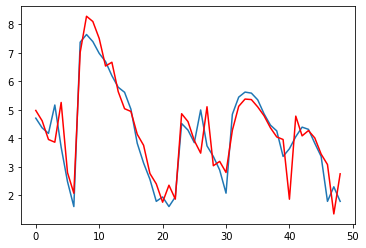

array([-0.46283324, -0.41525223, -0.44490707, -0.48597177])

In [0]:
Y = weekly_CCAA.Fallecidos.values
X=np.column_stack([CCAA_Weeks[weekly_CCAA.columns[8:16]].values])
size = int(len(X) * 0.66)
X_train, X_test, y_train, y_test = X[0:size], X[size:(len(X))],Y[0:size], Y[size:(len(Y))]
# Create model
linreg = LinearRegression()
linreg.fit(X_train, y_train)
# Calculate our y hat (how our model performs against the test data held off)
y_pred = linreg.predict(X_test)

from sklearn.metrics import mean_squared_error, mean_absolute_error
# See our Squared Mean Error score and Root Mean Squared Error:
test_mse = mean_squared_error(y_test, y_pred)
test_rmse = np.sqrt(test_mse)
# See our Mean Absolute Error
test_mae = mean_absolute_error(y_test, y_pred)
print(f"the test MAE is: {test_mae}")
pyplot.plot(y_test)
pyplot.plot(y_pred, color='red')
pyplot.show()

from sklearn.model_selection import cross_val_score
cv_4_results = cross_val_score(linreg, X, Y, cv=4, scoring="neg_mean_absolute_error")
cv_4_results

### Coefficients

In [0]:

#coef_ : array, shape (n_features, ) or (n_targets, n_features)
print("Coefficient for [Diagnosed 1 week ago 	Fallecidos 1 week ago 	Hospitalizados 1 week ago 	UCI 1 week ago 	Diagnosed 2 weeks ago 	Fallecidos 2 weeks ago 	Hospitalizados 2 weeks ago 	UCI 2 weeks ago ]")
print(linreg.coef_)

#intercept_ : array  Independent term in the linear model.

print("intercept", linreg.intercept_) 

Coefficient for [Diagnosed 1 week ago 	Fallecidos 1 week ago 	Hospitalizados 1 week ago 	UCI 1 week ago 	Diagnosed 2 weeks ago 	Fallecidos 2 weeks ago 	Hospitalizados 2 weeks ago 	UCI 2 weeks ago ]
[ 1.55645003e-04  1.21322569e+00 -1.05774777e-04 -2.35450261e-04
  9.07472045e-06 -5.06222139e-01  5.86462141e-05  1.12331720e-04]
intercept 0.8573621015844521


## Results
With the last modifications, the model works better, with a MAE of 0.503 which is way more precise than the other ones, and a cross validation of (-0.46283324, -0.41525223, -0.44490707, -0.48597177). This means that the training model is predicting better the real deaths of each week

## Scatter plot (y_predicted vs y_real)
We want to have a visual idea of the similarity between real and predicted deaths.

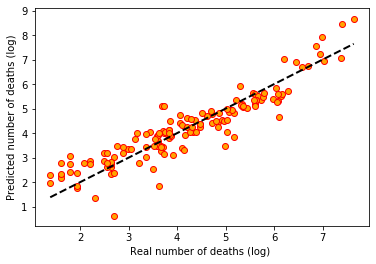

In [0]:
from sklearn import datasets
from sklearn.model_selection import cross_val_predict
from sklearn import linear_model
import matplotlib.pyplot as plt
y=Y
# cross_val_predict returns an array of the same size as `y` where each entry
# is a prediction obtained by cross validation:
predicted = cross_val_predict(linreg, X, y, cv=4)

fig, ax = plt.subplots()
ax.scatter(y, predicted, edgecolors=(1, 0, 0), c='orange')
ax.plot([y.min(), y.max()], [y.min(), y.max()], 'k--', lw=2)
ax.set_xlabel('Real number of deaths (log) ')
ax.set_ylabel('Predicted number of deaths (log)')
plt.show()

### Conclusions of the Logarithmic Scatter Plot
In this plot, the closer the points to the black line, the better! So, this model follows the Fallecidos trends.As we have been working with the logarithmic values for the columns related to deaths, now we want to convert these values (from logarithmic to linear) in order to adjust it to the reality.

### From Logarithmic to Linear

In [0]:
# Remember: ln(x)=a --> a=e^x
import math
linear_y=[math.exp(x) for x in y]
linear_ypred=[math.exp(x) for x in predicted]

Now, we will plot the same as before but with linear scale:

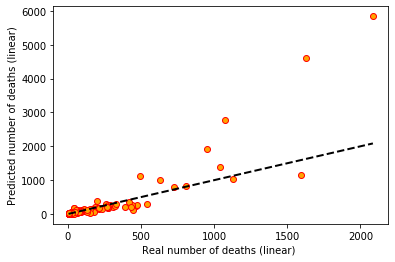

In [0]:
fig, ax = plt.subplots()
ax.scatter(linear_y, linear_ypred, edgecolors=(1, 0, 0), c='orange')
ax.plot([min(linear_y), max(linear_y)], [min(linear_y), max(linear_y)], 'k--', lw=2)
ax.set_xlabel('Real number of deaths (linear) ')
ax.set_ylabel('Predicted number of deaths (linear)')
plt.show()

### Conclusions (Linear Scatter Plot)
We can conclude that our model works better when predicting a "low" number of deaths, but it does not work properly when predicting a larger number of deaths (however, the normal situation requires a good model for a low number of deaths).

## Random Forest model

In [0]:
### Random Forest
with logaritmic dataframe

In [0]:
from sklearn.ensemble import RandomForestRegressor

In [0]:
from sklearn.model_selection import train_test_split
del(weekly_CCAA['CCAA'])
train, test = train_test_split(weekly_CCAA, test_size=0.2)

In [0]:
y_train = train.Fallecidos
x_train = train.drop(['Fallecidos'], axis = 1) #removing fallecidos

clf = RandomForestRegressor(n_estimators=10)
clf = clf.fit(x_train, y_train)
pred = clf.predict(x_train)
display(pred)

y_test = test.Fallecidos
x_test = test.drop(['Fallecidos'], axis = 1)
y_pred = clf.predict(x_test)

In [0]:
test_mae = mean_absolute_error(y_test, y_pred)
print("test set MAE", test_mae)
X = weekly_CCAA.drop(['Fallecidos'], axis = 1)
cv_4_results= cross_val_score(clf, X , weekly_CCAA.Fallecidos, cv=4, scoring="neg_mean_absolute_error") 
cv_4_results

test set MAE 0.3780973865577118


array([-0.41624041, -0.29607261, -0.34234693, -0.28258883])

The outcome with the random tree forest seems better than the linear regression, both models can be useful for our purpose to predict the death of next week and the two models can be used in different ways according to their strenghts:

With the linear regression we can interpretate the relation between the features and the deaths: trying to act on the source to reduce the deaths from covid-19 (e.g., with proactive diagnostic rather than reactive, in order to reduce the number of patients that requires hospitalizations)

With the random tree forest we have a more precise information on the number of deaths caused by covid-19 (no information on the cause), this can still be used to analyse the trend of the deaths, predict a possible second wave or a possible decrease of deaths caused by covid-19